In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import fastprogress
import ipywidgets
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import axes3d
import numpy
import pymc3
import scipy

import pyrff

### Specify Synthetic Problem

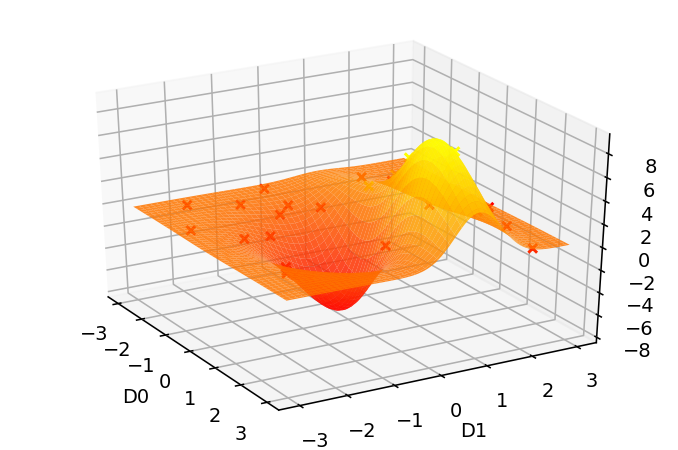

In [3]:
σ_true = 0.1
D = 2
BOUNDS = numpy.array([
    (-3, 3)
    for d in range(D)
])

def truth(x):
    """ Evaluates the groundtruth function.
    
    Parameters
    ----------
    x : numpy.ndarray
        (?, 2) coordinates
        
    Returns
    -------
    y : numpy.ndarray
        (?,) function evaluations
    """
    x_, y_ = x.T
    Z1 = numpy.exp(-(x_**2 + y_**2) / 2) / (2 * numpy.pi)
    Z2 = (numpy.exp(-(((x_ - 1) / 1.5)**2 + ((y_ - 1) / 0.5)**2) / 2) / (2 * numpy.pi * 0.5 * 1.5))
    Z = (Z2 - Z1) * 50
    return Z

def observe(x, sigma=σ_true):
    y = truth(x)
    assert y.shape == (len(x),)
    return numpy.random.normal(y, sigma, size=(len(x),))

# make observations
X = numpy.random.RandomState(2020).uniform(
    low=BOUNDS[:,0],
    high=BOUNDS[:,1],
    size=(30,D)
)
Y = observe(X)


if D == 2:
    fig = pyplot.figure(dpi=140)
    ax = fig.add_subplot(111, projection='3d')

    # create X-coordinates for plotting
    n = 100
    x_dense = numpy.array(numpy.meshgrid(*[
        numpy.linspace(lb, ub, n)
        for lb, ub in BOUNDS
    ])).T.reshape(n*n, D)
    # evaluate at these X-coordinates
    z = truth(x_dense)

    # Plot a basic wireframe.
    ax.plot_surface(
        x_dense[:,0].reshape(n,n), x_dense[:,1].reshape(n,n), z.reshape(n,n),
        alpha=0.85, cmap=cm.autumn
    )
    ax.set_xlabel('D0')
    ax.set_ylabel('D1')
    ax.set_zlabel('f(x,y)')
    
    # plot observations
    ax.scatter(
        X[:,0], X[:,1], Y,
        color=cm.autumn(Y),
        marker='x', label='$Y_{obs}$',
        alpha=1
    )
    ax.view_init(elev=30, azim=-30)

    pyplot.show()

In [4]:
# create coordinates for cross-sections
X_denses = {}
for d, (lb, ub) in enumerate(BOUNDS):
    x_dense = numpy.zeros((100, D))
    x_dense[:,d] = numpy.linspace(lb, ub, 100)
    X_denses[f'D{d}'] = x_dense
del x_dense

### Fit Gaussian Process with `PyMC3`

In [5]:
with pymc3.Model() as pmodel:
    # as lengthscale, take the width of every bound
    span = numpy.ptp(BOUNDS, axis=1)
    ls = pymc3.Gamma('ls', alpha=2, beta=1, shape=span.shape)
    
    # expect a variance of the functions around 1
    scaling = pymc3.Lognormal('scaling', mu=0, sd=0.5)

    # for the observation noise, cheat by centering on the true value
    sigma = pymc3.Lognormal('sigma', mu=σ_true, sd=0.05)

    # construct the GP
    mean_func = pymc3.gp.mean.Zero() # for RFF, the mean must be 0 !!!
    cov_func = scaling**2 * pymc3.gp.cov.ExpQuad(
        input_dim=D,
        ls=ls
    )
    gp = pymc3.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    if X is not None:
        f = gp.prior('f', X=X)
        # set up likelihood                
        # note that `sigma` could also be a function - see Marginal Likelihood Example notebook from PyMC3
        L = pymc3.Normal(
            'L',
            mu=f, sigma=sigma,
            observed=Y
        )
        
with pmodel:
    mp = pymc3.find_MAP()
    
with pmodel:
    trace = pymc3.sample(tune=1000, draws=1000)
    idata = arviz.from_pymc3(trace)

C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zufal\Miniconda3\envs\pm3-dev\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional i

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 262 seconds.


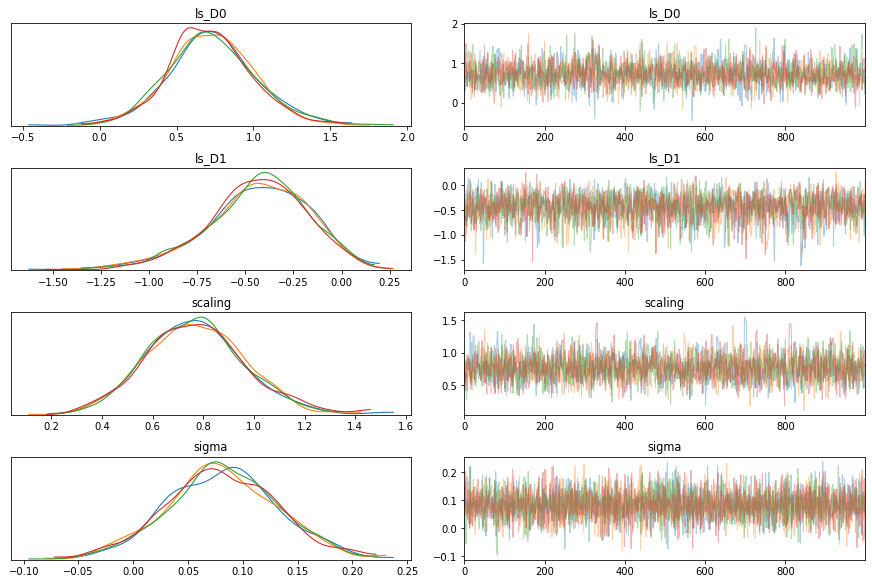

In [6]:
axs = arviz.plot_trace(trace, var_names=['ls', 'scaling', 'sigma'], transform=numpy.log)
for d, axr in zip(range(D), axs):
    dname = f'D{d}'
    for ax in axr:
        ax.set_title(f'ls_{dname}')
pyplot.show()

In [7]:
# add observations, conditioned on slices of x-coordinates to the model
with pmodel:
    if X is not None:
        for dname, x_dense in X_denses.items():
            gp.conditional(dname, Xnew=x_dense)
    else:
        for dname, x_dense in X_denses.items():
            gp.prior(dname, X=x_dense)

In [8]:
# sample the GP at those coordinates, using the MAP hyperparameters
with pmodel:
    pp_map = pymc3.sample_posterior_predictive(
        [mp]*1000,
        var_names=list(X_denses.keys()),
        random_seed=None
    )

In [9]:
# also sample the GPs created from hyperparameter posterior samples
with pmodel:
    pp_mcmc = pymc3.sample_posterior_predictive(
        idata.posterior,
        var_names=list(X_denses.keys()),
        random_seed=None
    )

### Sample RFF approximations

In [10]:
M = 200
N = 1000
rffs_map = [
    pyrff.sample_rff(
        lengthscales=mp['ls'],
        scaling=mp['scaling'],
        noise=mp['sigma'],
        # because the model uses the ExpQuad kernel:
        kernel_nu=numpy.inf,
        X=X,
        Y=Y,
        M=M,
    )
    for i in fastprogress.progress_bar(range(N))
]

In [11]:
C = idata.posterior.dims['chain']
S = idata.posterior.dims['draw']
posterior_indices = numpy.random.randint(
    low=0,
    high=C * S,
    size=N
)
rffs_mcmc = [
    pyrff.sample_rff(
        lengthscales=idata.posterior['ls'].values.reshape(C * S, D)[i],
        scaling=idata.posterior['scaling'].values.reshape(C * S,)[i],
        noise=idata.posterior['sigma'].values.reshape(C * S,)[i],
        # because the model uses the ExpQuad kernel:
        kernel_nu=numpy.inf,
        X=X,
        Y=Y,
        M=M,
    )
    for i in fastprogress.progress_bar(posterior_indices)
]

### Compare RFF approximations with MAP

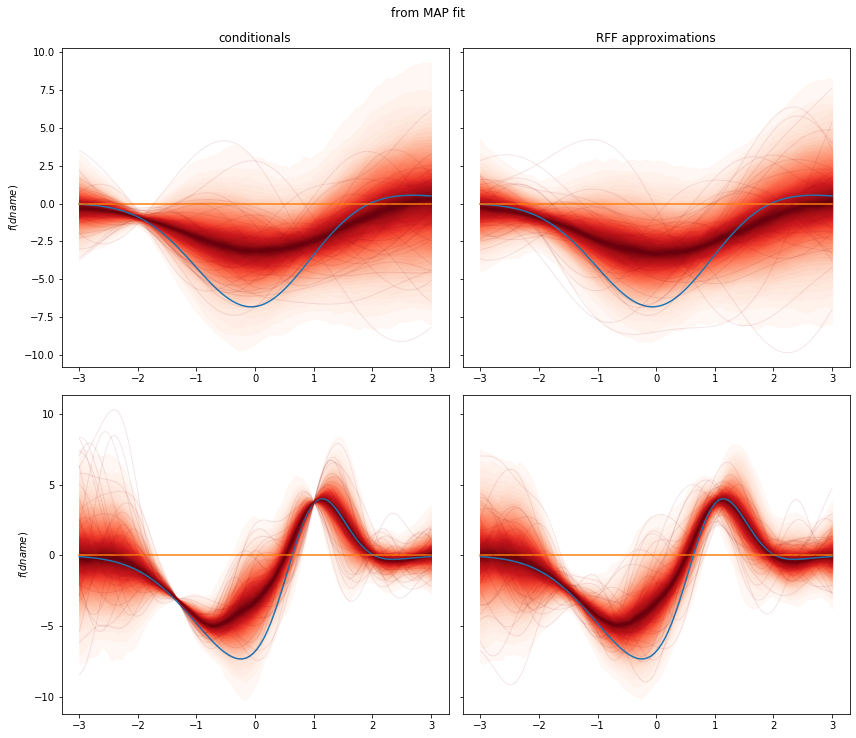

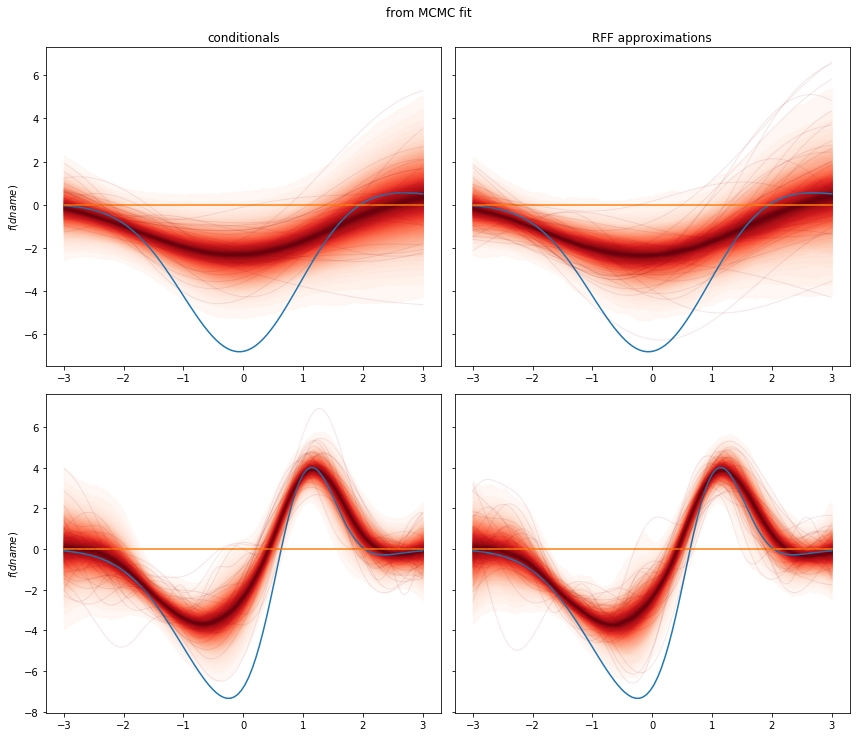

In [12]:
for label, pp, rffs in [
    ('MAP', pp_map, rffs_map),
    ('MCMC', pp_mcmc, rffs_mcmc),
]:
    fig, axs = pyplot.subplots(nrows=D, ncols=2, figsize=(12, 5*D), squeeze=False, sharey='row')

    for d, (left, right) in enumerate(axs):
        dname = f'D{d}'
        x_dense = X_denses[dname]

        # plot functions
        for fname, f in [
                ('truth', truth),
                ('GP mean function', lambda x: gp.mean_func(x).eval())
            ]:
            left.plot(x_dense[:,d], f(x_dense), label=fname)
            right.plot(x_dense[:,d], f(x_dense), label=fname)

        # plot conditionals and approximations
        pymc3.gp.util.plot_gp_dist(left, pp[dname], x_dense[:,d])
        pymc3.gp.util.plot_gp_dist(right, numpy.array([
            f_rff(x_dense)
            for f_rff in rffs
        ]), x_dense[:,d])

        if D == 1:
            left.scatter(X[:,d], Y, label='$Y_{obs}$')
            right.scatter(X[:,d], Y, label='$Y_{obs}$')
        left.set_ylabel('$f({dname})$')

    axs[0,0].set_title('conditionals')
    axs[0,1].set_title('RFF approximations')
    fig.suptitle(f'from {label} fit', y=1.02)
    fig.tight_layout()
    pyplot.show()

### Run minimization on the RFF approximations to obtain $p(x_*|X,Y)$ samples

In [13]:
x_star = {}
for label, pp, rffs in [
    ('MAP', pp_map, rffs_map),
    ('MCMC', pp_mcmc, rffs_mcmc),
]:
    
    print(f'Minimizing RFFs obtained from {label} fit')

    # collect minima for all RFF functions
    x_star_x = []
    x_star_y = []
    for f_rff in fastprogress.progress_bar(rffs):
        x_best, y_best = pyrff.multi_start_fmin(
            fun=f_rff,
            x0s=numpy.random.uniform(low=BOUNDS[:,0], high=BOUNDS[:,1], size=(50, D)),
        )
        x_star_x.append(x_best)
        x_star_y.append(y_best)
    x_star[label] = (numpy.array(x_star_x), numpy.array(x_star_y))

Minimizing RFFs obtained from MAP fit


Minimizing RFFs obtained from MCMC fit


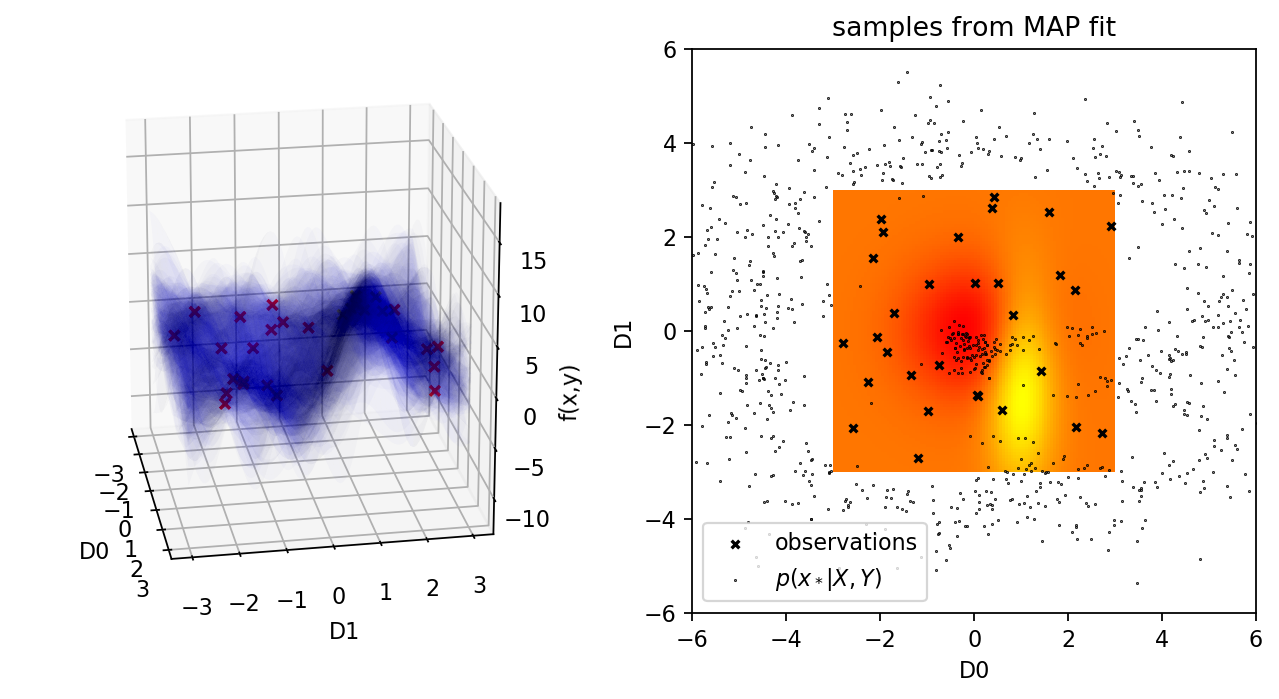

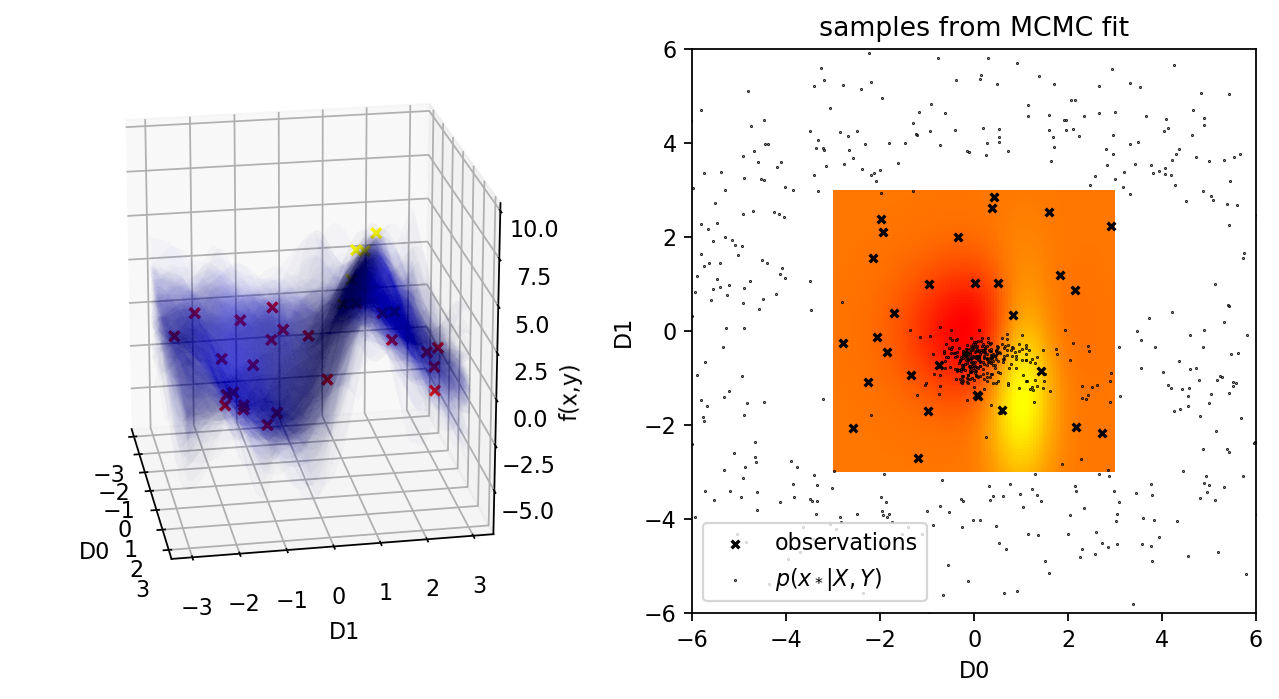

In [14]:
if D == 2:
    
    n_rff = 50
    # create X-coordinates for 2D plotting
    n = 100
    x_dense = numpy.array(numpy.meshgrid(*[
        numpy.linspace(lb, ub, n)
        for lb, ub in BOUNDS
    ])).T.reshape(n*n, D)


    # make the plot for both MAP and MCMC results
    for label, _, rffs in [
        ('MAP', pp_map, rffs_map),
        ('MCMC', pp_mcmc, rffs_mcmc),
    ]:
        x_star_x, x_star_y = x_star[label]
        
        fig = pyplot.figure(dpi=160, figsize=(10, 5))
        ax3d = fig.add_subplot(1, 2, 1, projection='3d')
        ax2d = fig.add_subplot(1, 2, 2)

        # plot observations
        ax3d.scatter(
            X[:,0], X[:,1], Y,
            color=cm.autumn(Y),
            marker='x', label='$Y_{obs}$',
            alpha=1
        )

        # plot some RFFs        
        for rff in rffs[:n_rff]:
            z = rff(x_dense)
            ax3d.plot_surface(
                x_dense[:,0].reshape(n,n), x_dense[:,1].reshape(n,n), z.reshape(n,n),
                #marker='.', s=0.2,
                alpha=1/n_rff, color='blue'
            )

        ax3d.set_xlabel('D0')
        ax3d.set_ylabel('D1')
        ax3d.set_zlabel('f(x,y)')
        ax3d.view_init(elev=20, azim=-10)
        
        # plot heatmap and optima to the right
        ax2d.imshow(
            truth(x_dense).reshape(n,n),
            extent=BOUNDS.flatten(),
            cmap=cm.autumn
        )
        ax2d.scatter(
            X[:, 0],
            X[:, 1],
            marker='x', color='black', s=12,
            label='observations'
        )
        ax2d.scatter(
            x_star_x[:, 0],
            x_star_x[:, 1],
            marker='.', color='black', s=0.5,
            label='$p(x_*|X,Y)$'
        )

        ax2d.set_title(f'samples from {label} fit')
        ax2d.set_xlabel('D0')
        ax2d.set_ylabel('D1')
        ax2d.set_xlim(*BOUNDS[0]*2)
        ax2d.set_ylim(*BOUNDS[1]*2)
        ax2d.legend()

        pyplot.show()